In [1]:
from typing import List, Dict, Set
import attrs
import sympy

import qualtran.testing as qlt_testing
from qualtran import (
    Bloq, BloqBuilder,
    QBit, QAny, QInt, QUInt,
    Register, Side, Signature,
)

from qualtran.drawing import show_bloq

In [2]:
# new imports
from qualtran.resource_counting import BloqCountT, SympySymbolAllocator
from qualtran.symbolics import SymbolicInt
from qualtran.drawing import show_call_graph

In [3]:
@attrs.frozen
class ModExp(Bloq):
    """Perform modular exponentiation `x = g^exponent mod p`.

    x and exponent are quantum variables; g and the modulus are classical constants.

    The exponent register has `n_exponent` bits.

    For simplicity, let's assume
        - a 32-bit "x" register.
    """

    g: int
    mod: int
    # Change alert! `n_exponent` is now a class attribute.
    n_exponent: SymbolicInt = 4

    @property
    def signature(self) -> 'Signature':
        return Signature([
            # Change alert! `n_exponent` now sets the size of the "exponent" register.
            Register('exponent', QUInt(bitsize=self.n_exponent)),
            Register('x', QUInt(bitsize=32))
        ])

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # We can override this method to list the "callees" of this bloq without
        # having to provide a full circuit construction.
        #
        # If we have an n-bit exponent register, we can do a modular exponentiation
        # with `n` controlled modular multiplies.
        #
        # This method expects that you return a set of tuples (bloq, count) where bloq
        # is a subbloq in this bloq's decomposition and count is the number of times it is called.
        #
        # See the API reference docs for Bloq.build_call_graph for details
        # https://qualtran.readthedocs.io/en/latest/reference/qualtran/Bloq.html#build_call_graph

        # Hint: you want the CtrlModMul bloq
        from qualtran.bloqs.factoring import CtrlModMul
        # https://qualtran.readthedocs.io/en/latest/bloqs/factoring/mod_mul.html

        # ! ----------------------------
        k = ssa.new_symbol('k')
        return {
            (CtrlModMul(k=k, mod=self.mod, bitsize=32), self.n_exponent)
        }
        # ! ----------------------------

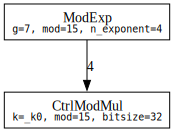

In [4]:
m = ModExp(g=7, mod=15)
graph, sigma = m.call_graph(max_depth=1)
show_call_graph(graph)

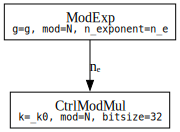

In [5]:
g, N, n_e = sympy.symbols('g N n_e')
m = ModExp(g=g, mod=N, n_exponent=n_e)
graph, sigma = m.call_graph(max_depth=1)
show_call_graph(graph)